# Ictonyx Example: Scikit-Learn Models

The previous examples use TensorFlow and PyTorch. This one stays entirely in scikit-learn — no GPU required.

We'll cover:
1. **Classification** — three model families on the digits dataset, with a full statistical comparison
2. **Regression** — two models on a synthetic problem, using MSE as the metric

**Requirements:** `pip install ictonyx scikit-learn`

In [1]:
# If you're in Colab, uncomment the next line:
# !pip install ictonyx -q

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
from sklearn.datasets import load_digits, make_regression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

import ictonyx as ix
from ictonyx import (
    ModelConfig,
    ScikitLearnModelWrapper,
    ArraysDataHandler,
    run_variability_study,
    compare_two_models,
    compare_multiple_models,
    plot_comparison_boxplots,
    plot_variability_summary,
)

print(f"Ictonyx v{ix.__version__}")

Ictonyx v0.3.2


---

## Part 1: Classification

### Load Data

The digits dataset: 1,797 samples, 64 features (8×8 pixel values), 10 classes.
StandardScaler helps the neural network converge — tree methods don't care, but it doesn't hurt them.

In [3]:
digits = load_digits()
X_clf = StandardScaler().fit_transform(digits.data)
y_clf = digits.target

data_clf = ArraysDataHandler(X_clf, y_clf)

print(f"Samples: {len(X_clf)}")
print(f"Features: {X_clf.shape[1]}")
print(f"Classes: {len(np.unique(y_clf))}")

Samples: 1797
Features: 64
Classes: 10


### Define Three Model Builders

Each builder is a factory function that returns a freshly initialized, wrapped model.
This is how Ictonyx ensures each run starts from scratch.

We're testing three model families that approach the problem differently:
- **MLP** — gradient-based, sensitive to initialization
- **RandomForest** — bagging with random feature subsets
- **GradientBoosting** — sequential boosting, less random than RF

In [4]:
def create_mlp(config: ModelConfig) -> ScikitLearnModelWrapper:
    """MLP: two hidden layers, early stopping."""
    return ScikitLearnModelWrapper(
        MLPClassifier(
            hidden_layer_sizes=(64, 32),
            max_iter=300,
            early_stopping=True,
            validation_fraction=0.15,
        )
    )

def create_rf(config: ModelConfig) -> ScikitLearnModelWrapper:
    """RandomForest: 30 trees, sqrt features per split."""
    return ScikitLearnModelWrapper(
        RandomForestClassifier(n_estimators=30, max_features="sqrt")
    )

def create_gb(config: ModelConfig) -> ScikitLearnModelWrapper:
    """GradientBoosting: 100 stages, shallow trees."""
    return ScikitLearnModelWrapper(
        GradientBoostingClassifier(n_estimators=100, max_depth=3)
    )

# Sanity check
for name, builder in [("MLP", create_mlp), ("RF", create_rf), ("GB", create_gb)]:
    w = builder(ModelConfig())
    print(f"{name}: {type(w.model).__name__}")

MLP: MLPClassifier
RF: RandomForestClassifier
GB: GradientBoostingClassifier


### Run Variability Studies

10 runs per model. For scikit-learn models, `epochs` doesn't control training iterations
(that's handled by each estimator's own parameters) — the runner just calls `fit()` once per run.

In [5]:
config = ModelConfig({"epochs": 1, "batch_size": 32, "verbose": 0})

print("Training MLP (10 runs)...")
mlp_results = run_variability_study(
    model_builder=create_mlp, data_handler=data_clf,
    model_config=config, num_runs=10, seed=42,
)

print()
print("Training RandomForest (10 runs)...")
rf_results = run_variability_study(
    model_builder=create_rf, data_handler=data_clf,
    model_config=config, num_runs=10, seed=42,
)

print()
print("Training GradientBoosting (10 runs)...")
gb_results = run_variability_study(
    model_builder=create_gb, data_handler=data_clf,
    model_config=config, num_runs=10, seed=42,
)

Training MLP (10 runs)...
Loading and preparing data...
Array splits - Train: 1257, Val: 180, Test: 360
Data loaded successfully

Starting Variability Study
  Runs: 10
  Epochs per run: 1
  Execution mode: in standard mode
  Seed: 42



Variability Study: 100%|████████████| 10/10 [00:14<00:00,  1.45s/run, val_accuracy=0.9778]


--------------------------------------------------

Study Summary:
  Successful runs: 10/10
  train_accuracy: 0.9845 (SD = 0.0082)
  train_loss: 0.0155 (SD = 0.0082)
  val_accuracy: 0.9567 (SD = 0.0195)
  val_loss: 0.0433 (SD = 0.0195)

Training RandomForest (10 runs)...
Loading and preparing data...
Array splits - Train: 1257, Val: 180, Test: 360
Data loaded successfully

Starting Variability Study
  Runs: 10
  Epochs per run: 1
  Execution mode: in standard mode
  Seed: 42



Variability Study: 100%|████████████| 10/10 [00:09<00:00,  1.01run/s, val_accuracy=0.9722]


--------------------------------------------------

Study Summary:
  Successful runs: 10/10
  train_accuracy: 1.0000 (SD = 0.0000)
  train_loss: 0.0000 (SD = 0.0000)
  val_accuracy: 0.9744 (SD = 0.0083)
  val_loss: 0.0256 (SD = 0.0083)

Training GradientBoosting (10 runs)...
Loading and preparing data...
Array splits - Train: 1257, Val: 180, Test: 360
Data loaded successfully

Starting Variability Study
  Runs: 10
  Epochs per run: 1
  Execution mode: in standard mode
  Seed: 42



Variability Study: 100%|████████████| 10/10 [00:43<00:00,  4.33s/run, val_accuracy=0.9611]


--------------------------------------------------

Study Summary:
  Successful runs: 10/10
  train_accuracy: 1.0000 (SD = 0.0000)
  train_loss: 0.0000 (SD = 0.0000)
  val_accuracy: 0.9589 (SD = 0.0037)
  val_loss: 0.0411 (SD = 0.0037)


### Compare the Distributions

First, the raw numbers. Look at the standard deviations — some model families are inherently more variable than others.

In [6]:
for name, res in [("MLP", mlp_results), ("RF", rf_results), ("GB", gb_results)]:
    accs = res.get_metric_values("val_accuracy")
    print(f"{name:20s}  mean={np.mean(accs):.4f}  std={np.std(accs):.4f}  "
          f"range=[{np.min(accs):.4f}, {np.max(accs):.4f}]")

MLP                   mean=0.9567  std=0.0195  range=[0.9111, 0.9833]
RF                    mean=0.9744  std=0.0083  range=[0.9611, 0.9889]
GB                    mean=0.9589  std=0.0037  range=[0.9500, 0.9611]


### Statistical Comparison: All Three Models

When comparing three or more models, Ictonyx uses a two-step procedure:
1. **Kruskal-Wallis** omnibus test — is there *any* difference among the groups?
2. **Pairwise Mann-Whitney U** tests with Holm correction — *which* pairs differ?

This protects against false positives from running too many tests.

In [7]:
model_metrics = {
    "MLP": pd.Series(mlp_results.get_metric_values("val_accuracy")),
    "RandomForest": pd.Series(rf_results.get_metric_values("val_accuracy")),
    "GradientBoosting": pd.Series(gb_results.get_metric_values("val_accuracy")),
}

comparison = compare_multiple_models(model_metrics)

# Overall test
overall = comparison["overall_test"]
print(f"Omnibus test: {overall.test_name}")
print(f"p-value: {overall.p_value:.4f}")
print()

# Pairwise results
print("Pairwise comparisons (Holm-corrected):")
for pair_name, result in comparison["pairwise_comparisons"].items():
    p = result.corrected_p_value if result.corrected_p_value is not None else result.p_value
    if p < 0.001:
        sig = "***"
    elif p < 0.01:
        sig = "**"
    elif p < 0.05:
        sig = "*"
    else:
        sig = "ns"
    print(f"  {pair_name:45s}  p={p:.4f} {sig}  effect={result.effect_size:+.3f} ({result.effect_size_interpretation})")

print()
print(f"Significant pairs: {comparison['significant_comparisons']}")

Omnibus test: Kruskal-Wallis H-Test
p-value: 0.0021

Pairwise comparisons (Holm-corrected):
  MLP_vs_RandomForest                            p=0.0009 ***  effect=+0.610 (large)
  MLP_vs_GradientBoosting                        p=0.0009 ***  effect=-0.070 (negligible)
  RandomForest_vs_GradientBoosting               p=0.0009 ***  effect=-0.930 (large)

Significant pairs: ['MLP_vs_RandomForest', 'MLP_vs_GradientBoosting', 'RandomForest_vs_GradientBoosting']


### Visualize

Boxplots make the overlap (or separation) between distributions immediately visible.

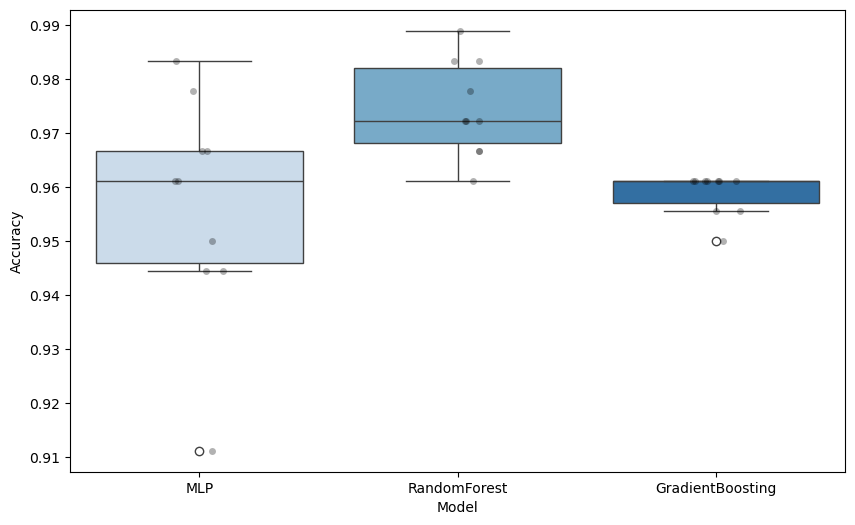

In [8]:
comparison_data = {
    "raw_data": {
        "MLP": mlp_results.get_metric_values("val_accuracy"),
        "RandomForest": rf_results.get_metric_values("val_accuracy"),
        "GradientBoosting": gb_results.get_metric_values("val_accuracy"),
    }
}

plot_comparison_boxplots(comparison_data)

---

## Part 2: Regression

Ictonyx isn't limited to classification. Here we generate a synthetic regression problem and compare
an MLP regressor against a RandomForest regressor using loss (MSE).

### Generate Data

A linear problem with 8 features (5 informative, 3 noise) and moderate Gaussian noise.

In [9]:
X_reg, y_reg = make_regression(
    n_samples=500, n_features=8, n_informative=5,
    noise=20.0, random_state=42,
)
X_reg = StandardScaler().fit_transform(X_reg).astype(np.float32)
y_reg = y_reg.astype(np.float32)

data_reg = ArraysDataHandler(X_reg, y_reg)

print(f"Samples: {len(X_reg)}")
print(f"Features: {X_reg.shape[1]}")
print(f"Target range: [{y_reg.min():.1f}, {y_reg.max():.1f}]")

Samples: 500
Features: 8
Target range: [-408.8, 336.6]


### Define Regression Builders

In [10]:
def create_mlp_reg(config: ModelConfig) -> ScikitLearnModelWrapper:
    """MLP regressor: two hidden layers."""
    return ScikitLearnModelWrapper(
        MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, early_stopping=True)
    )

def create_rf_reg(config: ModelConfig) -> ScikitLearnModelWrapper:
    """RandomForest regressor: 30 trees."""
    return ScikitLearnModelWrapper(
        RandomForestRegressor(n_estimators=30)
    )

### Run and Compare

For regression models, Ictonyx tracks loss (mean squared error) and R² automatically.

In [11]:
config = ModelConfig({"epochs": 1, "verbose": 0})

print("Training MLP Regressor (10 runs)...")
mlp_reg_results = run_variability_study(
    model_builder=create_mlp_reg, data_handler=data_reg,
    model_config=config, num_runs=10, seed=42,
)

print()
print("Training RF Regressor (10 runs)...")
rf_reg_results = run_variability_study(
    model_builder=create_rf_reg, data_handler=data_reg,
    model_config=config, num_runs=10, seed=42,
)

Training MLP Regressor (10 runs)...
Loading and preparing data...
Array splits - Train: 350, Val: 50, Test: 100
Data loaded successfully

Starting Variability Study
  Runs: 10
  Epochs per run: 1
  Execution mode: in standard mode
  Seed: 42



Variability Study: 100%|████████████| 10/10 [00:13<00:00,  1.35s/run, val_accuracy=0.9728]


--------------------------------------------------

Study Summary:
  Successful runs: 10/10
  train_accuracy: 0.9719 (SD = 0.0034)
  train_loss: 0.0281 (SD = 0.0034)
  val_accuracy: 0.9736 (SD = 0.0017)
  val_loss: 0.0264 (SD = 0.0017)

Training RF Regressor (10 runs)...
Loading and preparing data...
Array splits - Train: 350, Val: 50, Test: 100
Data loaded successfully

Starting Variability Study
  Runs: 10
  Epochs per run: 1
  Execution mode: in standard mode
  Seed: 42



Variability Study: 100%|████████████| 10/10 [00:10<00:00,  1.01s/run, val_accuracy=0.8474]


--------------------------------------------------

Study Summary:
  Successful runs: 10/10
  train_accuracy: 0.9745 (SD = 0.0012)
  train_loss: 0.0255 (SD = 0.0012)
  val_accuracy: 0.8375 (SD = 0.0090)
  val_loss: 0.1625 (SD = 0.0090)


In [12]:
# Check available metrics for regression models
print("Available metrics:", mlp_reg_results.get_available_metrics())

Available metrics: ['train_accuracy', 'train_loss', 'val_accuracy', 'val_loss']


In [13]:
# Compare on val_loss (MSE for regression)
for name, res in [("MLP", mlp_reg_results), ("RF", rf_reg_results)]:
    losses = res.get_metric_values("val_loss")
    print(f"{name:12s}  mean_loss={np.mean(losses):.4f}  std={np.std(losses):.4f}  "
          f"range=[{np.min(losses):.4f}, {np.max(losses):.4f}]")

MLP           mean_loss=0.0264  std=0.0017  range=[0.0244, 0.0307]
RF            mean_loss=0.1625  std=0.0090  range=[0.1459, 0.1747]


In [14]:
# Statistical test on val_loss
mlp_losses = pd.Series(mlp_reg_results.get_metric_values("val_loss"))
rf_losses = pd.Series(rf_reg_results.get_metric_values("val_loss"))

reg_comparison = compare_two_models(mlp_losses, rf_losses)

print(f"Test: {reg_comparison.test_name}")
print(f"p-value: {reg_comparison.p_value:.4f}")
print(f"Effect size: {reg_comparison.effect_size:.3f} ({reg_comparison.effect_size_interpretation})")
print()
print(reg_comparison.conclusion)

Test: Independent Comparison (Welch's t-test)
p-value: 0.0000
Effect size: -14.299 (large)




---

## Summary

The workflow is the same regardless of model family or task type:
1. Write a factory function that returns a fresh `ScikitLearnModelWrapper`
2. Call `run_variability_study()` to train it N times
3. Use `compare_two_models()` or `compare_multiple_models()` to test whether differences are real

Ictonyx handles the seeding, metric extraction, and statistical testing.
You handle the modeling decisions.